In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
import tensorflow as tf

2024-06-10 14:30:12.866512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 14:30:12.866610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 14:30:12.974554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
gpus = tf.config.list_physical_devices("GPU")
print(f"Available GPUs: {gpus}")

# Make sure TensorFlow uses all GPUs
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus, "GPU")
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [5]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
validation_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

In [7]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
df.columns = ['number','borderlands','sentiment','text']
validation_df.columns = ['number','borderlands','sentiment','text']

In [9]:
print('+'*100)
print("Top 5 values in dataset")
df.head()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Top 5 values in dataset


,number,borderlands,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [10]:
print('='*100)
print('Top 5 values in validation dataset')
validation_df.head()

Top 5 values in validation dataset


,number,borderlands,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [11]:
df.isna().sum()

number           0
borderlands      0
sentiment        0
text           686
dtype: int64

## Drop the null values Because it was the text document

In [12]:
df = df.dropna()

In [13]:
df.isna().sum()

number         0
borderlands    0
sentiment      0
text           0
dtype: int64

## We know that the text are needed to analyse the sentiment of thedataset

In [14]:
df = df.drop(['number','borderlands'],axis=1)
validation_df = validation_df.drop(['number','borderlands'],axis=1)

In [15]:
df.head()

,sentiment,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [16]:
validation_df.head()

,sentiment,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


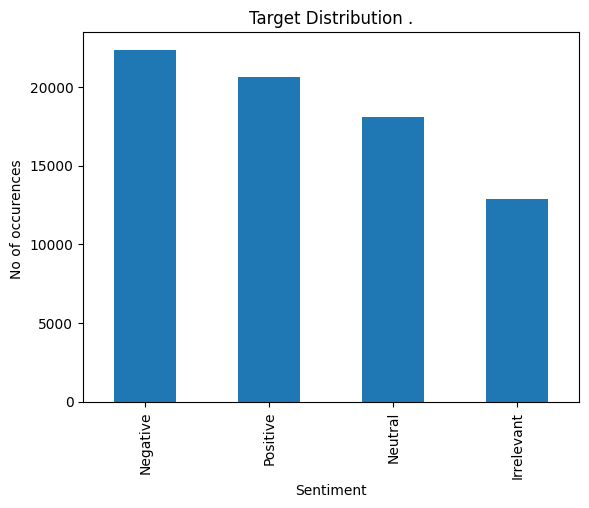

In [17]:
value_counts_target = df['sentiment'].value_counts()
value_counts_target.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('No of occurences ')
plt.title('Target Distribution .')
plt.show()

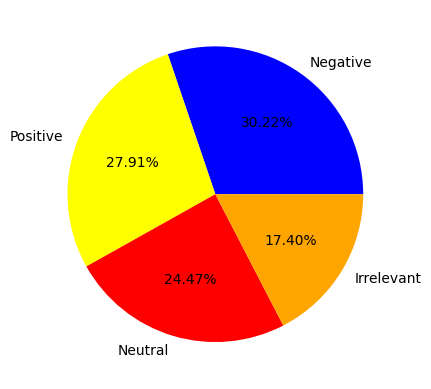

In [18]:
plt.pie(value_counts_target,labels=value_counts_target.index,autopct="%1.2f%%",colors=['blue','yellow','red','orange'])
plt.show()

## Define Stemming for finding the root word of that word

In [19]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

## Find unique words by removing stop word, remove special characters and numbers where they don't retain any information about the sentiment where the sentiment depends on the unique words 


# You look bad -> negative
# You look fanstastic -> positive
# I think this food was not so bad -> neutral

In [20]:
## iterate over the text remove stopwords, lemmatize the word
def preprocess_text(data):
    lis = list()
    for i in data:
        ss = re.sub('[^a-zA-Z]',' ',i)## Remove all values except the aphabets
        ss = ss.lower()
        ss = ss.split()
        ss = [f for f in ss if f not in set(stopwords.words('english'))]
        ss = [stemmer.stem(l) for l in ss]
        ss = ' '.join(ss)
        lis.append(ss)
    return lis

## Apply preprocessing on the text data

In [21]:
text_data = preprocess_text(df['text'])
validation_text_data = preprocess_text(validation_df['text'])

In [22]:
text_data[:5]

['come border kill',
 'im get borderland kill',
 'im come borderland murder',
 'im get borderland murder',
 'im get borderland murder']

In [23]:
validation_text_data[:5]

['bbc news amazon boss jeff bezo reject claim compani act like drug dealer bbc co uk news av busin',
 'microsoft pay word function poorli samsungu chromebook',
 'csgo matchmak full closet hack truli aw game',
 'presid slap american face realli commit unlaw act acquitt discov googl vanityfair com news',
 'hi eahelp madelein mccann cellar past year littl sneaki thing escap whilst load fifa point took card use paypal account work help resolv pleas']

## Define the vocabulary size randomly which means the number of unique words in the dataset

In [24]:
voc_size = 5000
voc_size 

5000

## Create an pad sequences for the embedding layer

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

## One Hot representation of the data with the total no of words in the corpus

In [26]:
one_hot_rep = [one_hot(words,voc_size) for words in text_data]
one_hot_rep_test = [one_hot(words,voc_size) for words in validation_text_data]

In [27]:
one_hot_rep[:5]

[[4030, 3566, 4319],
 [3078, 4819, 2426, 4319],
 [3078, 4030, 2426, 4311],
 [3078, 4819, 2426, 4311],
 [3078, 4819, 2426, 4311]]

In [28]:
one_hot_rep_test[:5]

[[1762,
  2853,
  1458,
  1308,
  4839,
  3700,
  4505,
  240,
  2238,
  301,
  3277,
  1907,
  2399,
  1762,
  3100,
  822,
  2853,
  4072,
  1828],
 [1412, 3682, 521, 3372, 1008, 4547, 2036],
 [3364, 3596, 3987, 75, 2674, 3344, 1330, 2125],
 [1661,
  1132,
  1612,
  1127,
  3671,
  3771,
  4655,
  301,
  151,
  1322,
  188,
  4326,
  3749,
  2853],
 [1871,
  1805,
  2550,
  2021,
  3146,
  209,
  2047,
  4953,
  358,
  4957,
  2384,
  561,
  499,
  3832,
  1282,
  4444,
  2774,
  3629,
  234,
  3129,
  3597,
  2874,
  359,
  3265]]

# Make these into the padded sequences for the model where we need to and find maximum text in the data make that as sentence length
## Make prepadding which is the make the texts into the equal length where put zeros in front of the datas

In [29]:
sent_length = max([len(i) for i in text_data]) + 2
embedded_docs = pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)
embedded_docs_test = pad_sequences(one_hot_rep_test,padding='pre',maxlen=sent_length)

# LSTM RNN
## train the model with the lstm rnn to predict the sentiment in the text

In [30]:
from tensorflow.keras.layers import Dense,LSTM,Embedding,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

In [31]:
embedding_vector_features = 10
model = Sequential([
    Embedding(voc_size,embedding_vector_features,input_length=sent_length),
    LSTM(1000),
    Dropout(0.3),
    BatchNormalization(),
    Dense(4,activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
model.compile(optimizer = 'adam',metrics=['accuracy'],loss='sparse_categorical_crossentropy')

## Summarize the model

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Datas for training and testing

In [34]:
X = embedded_docs
X_test = embedded_docs_test

## Convert the Sentiments into the labels which will be numbers 

In [35]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])
y_test = label_encoder.transform(validation_df['sentiment'])

In [36]:
classes = label_encoder.classes_
print("Classes of the models :",classes)

Classes of the models : ['Irrelevant' 'Negative' 'Neutral' 'Positive']


## Train the model with the test data as 0.5 where we made the batch size as 32 and 2 epochs will be happened

In [37]:
model.fit(X,y,validation_split=0.5,epochs=2,batch_size=32)

Epoch 1/2
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 279s 235ms/step - accuracy: 0.2981 - loss: 1.5344 - val_accuracy: 0.3902 - val_loss: 1.4489
Epoch 2/2
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 273s 236ms/step - accuracy: 0.5984 - loss: 0.9951 - val_accuracy: 0.3723 - val_loss: 2.7682


## Find the accuracy score of the model and how it make predictions on test data

In [38]:
from sklearn.metrics import accuracy_score,confusion_matrix

## Print the accuracy Score of the test model

In [39]:
layers = model.predict(X_test)
predictions_values = np.argmax(layers,axis=1)
predicted_data = label_encoder.inverse_transform(predictions_values)
print(f"acuracy of the model is : {accuracy_score(y_test,predictions_values)*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
acuracy of the model is : 40.34%


In [40]:
print("Confusion Matrix: ",confusion_matrix(y_test,predictions_values))
dfs = pd.DataFrame(confusion_matrix(y_test,predictions_values),columns=classes,index=classes)
print(dfs.head())

Confusion Matrix:  [[  5 129  37   0]
 [  0 234  32   0]
 [  0 124 161   0]
 [  3 227  44   3]]
            Irrelevant  Negative  Neutral  Positive
Irrelevant           5       129       37         0
Negative             0       234       32         0
Neutral              0       124      161         0
Positive             3       227       44         3


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

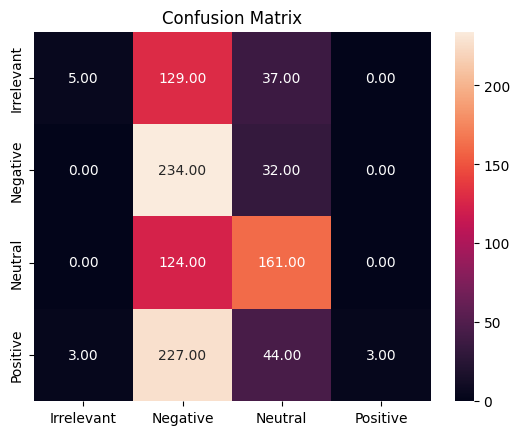

In [42]:
sns.heatmap(dfs,annot=True,fmt=".2f")
plt.title("Confusion Matrix")
plt.show()

## Sample datas and make predictions how our model predict it

In [43]:
text = ["Hii I am Sathish I am excited to share my experience my journey of my life!","I Love this world",'I am ready to face the challenges','meaning of life has been changed','What do yo need in your life',"made a sentiment along the axis ","What sentiment has been provided with the dataset?"]
text_data = preprocess_text(text)
print(text_data)

['hii sathish excit share experi journey life', 'love world', 'readi face challeng', 'mean life chang', 'yo need life', 'made sentiment along axi', 'sentiment provid dataset']


## provide one hot representation of datas

In [44]:
one_hot_rep_new_data = [one_hot(words,voc_size) for words in text_data]
print(one_hot_rep_new_data)

[[4350, 1573, 930, 560, 2025, 3861, 2031], [3941, 2245], [3026, 1127, 1778], [1243, 2031, 1735], [56, 2725, 2031], [4832, 4842, 1447, 2065], [4842, 3897, 3103]]


In [45]:
embed_new_text_data = pad_sequences(one_hot_rep_new_data,padding='pre',maxlen=sent_length)
print(embed_new_text_data)

[[   0    0    0 ... 2025 3861 2031]
 [   0    0    0 ...    0 3941 2245]
 [   0    0    0 ... 3026 1127 1778]
 ...
 [   0    0    0 ...   56 2725 2031]
 [   0    0    0 ... 4842 1447 2065]
 [   0    0    0 ... 4842 3897 3103]]


## make predictions using the trained model and show how does it predicts for the new model

In [46]:
layers = model.predict(embed_new_text_data)
predictions_values = np.argmax(layers,axis=1)
predicted_data = label_encoder.inverse_transform(predictions_values)
print("Predictions labels :",predictions_values)
print("Predicted sentiment :",predicted_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predictions labels : [0 1 1 1 1 1 1]
Predicted sentiment : ['Irrelevant' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative']


In [47]:
dff = pd.DataFrame(text_data,columns=['text'])
dff['Sentiment'] = predicted_data

In [48]:
dff.head()

,text,Sentiment
0,hii sathish excit share experi journey life,Irrelevant
1,love world,Negative
2,readi face challeng,Negative
3,mean life chang,Negative
4,yo need life,Negative
